In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (11.7, 8.27)})
sns.set_style("white")
sys.path.append("..")
import datetime as DT
import os
import rbf_functions
from rbf_functions import rbfs

In [2]:
rbfs = [
    rbf_functions.original_rbf,
    rbf_functions.squared_exponential_rbf,
    rbf_functions.inverse_quadratic_rbf,
    rbf_functions.inverse_multiquadric_rbf,
    rbf_functions.exponential_rbf,
    rbf_functions.matern32_rbf,
    rbf_functions.matern52_rbf,
]

# Load model output for each activation function

In [3]:
nfearchive = {}
for n in rbfs:
    nfearchive[n.__name__] = {}
for entry in rbfs:
    name = entry.__name__
    output_dir = f"../output/{name}/"
    for i in os.listdir(output_dir):
        if i.endswith("_hypervolume.csv"):
            archives_by_nfe = pd.read_csv(output_dir + i)
            nfes = archives_by_nfe["Unnamed: 0"].values
            u_nfes = np.unique(nfes)
            selected_nfe = u_nfes[0::5]
            selected_nfe = np.append(selected_nfe, u_nfes[-1::])
            nfearchive[name][int(i.split("_")[0])] = archives_by_nfe.loc[
                archives_by_nfe["Unnamed: 0"].isin(selected_nfe)
            ]

# Transform the dataframe back into platypus solution instances, to have a collection of solutions for each generation

In [4]:
from platypus import Solution, Problem, GenerationalDistance

n_rbfs = 4
n_objs = 6
n_vars = n_rbfs * 8

problem = Problem(n_vars, n_objs)

# matters for hypervolume
problem.directions[0] = Problem.MAXIMIZE  # hydropower
problem.directions[1] = Problem.MAXIMIZE  # atomic power plant
problem.directions[2] = Problem.MAXIMIZE  # baltimore
problem.directions[3] = Problem.MAXIMIZE  # chester
problem.directions[4] = Problem.MINIMIZE  # environment
problem.directions[5] = Problem.MAXIMIZE  # recreation

archives = {}
seeds = np.arange(10, 101, 10).tolist()
for n in rbfs:
    archives[n.__name__] = {}
    for i in seeds:
        archives[n.__name__][i] = {}
for entry in rbfs:
    name = entry.__name__
    for s in nfearchive[name]:  # nfearchive[name]:
        for nfe, generation in nfearchive[name][s].groupby("Unnamed: 0"):
            # we slice from 2, getting rid of the first two columns
            # which contain the NFE and ID of each solution
            archive = []
            for i, row in generation.iloc[:, 2::].iterrows():
                solution = Solution(problem)
                solution.objectives = row
                archive.append(solution)
            archives[name][s][nfe] = archive

# Load refsets for each rbf, turn into solutions sets

In [5]:
# load refsets for each rbf
ref_dir = "./refsets/"
ref_sets = {}
for n in rbfs:
    name = n.__name__
    ref_sets[name] = {}
    data = pd.read_csv(f"{ref_dir}{name}_refset.csv")
    ref_set = []
    for i, row in data.iterrows():
        solution = Solution(problem)
        solution.objectives = row
        ref_set.append(solution)
    ref_sets[name] = ref_set

# Or, load global refset for all rbfs, turn into solution set

In [6]:
# load refset for all rbfs
ref_dir = "./refsets"
ref_sets = {}
data = pd.read_csv(f"{ref_dir}/global_refset.csv")
ref_set = []
for i, row in data.iterrows():
    solution = Solution(problem)
    solution.objectives = row
    ref_set.append(solution)

# Calculate generational distance

In [7]:
# gd = GenerationalDistance(reference_set=ref_set)
# nfes = []
# gds = []
# for nfe, archive in archives.items():
#     nfes.append(nfe)
#     gds.append(gd.calculate(archive))

tempnfe = {}
tempgd = {}
nfe_sets = {}
gd_sets = {}
for rbf in archives:
    nfe_sets[rbf] = {}
    gd_sets[rbf] = {}
    #     gd = GenerationalDistance(reference_set=ref_sets[rbf])
    gd = GenerationalDistance(reference_set=ref_set)  # global refset
    print(f"started {rbf} at {DT.datetime.now().strftime('%H:%M:%S')}")
    for seed in archives[rbf]:
        nfe_sets[rbf][seed] = {}
        gd_sets[rbf][seed] = {}
        s_archives = archives[rbf][seed]
        nfes = []
        gds = []
        for nfe, archive in s_archives.items():
            nfes.append(nfe)
            gds.append(gd.calculate(archive))
        nfe_sets[rbf][seed] = nfes
        gd_sets[rbf][seed] = gds
        tempnfe[seed] = nfes
        tempgd[seed] = gds
        dfgd = pd.DataFrame.from_dict(tempgd, orient="index")
        dfnfe = pd.DataFrame.from_dict(tempnfe, orient="index")
        dfgd = dfgd.T
        dfnfe = dfnfe.T
        #         dfgd.to_csv(f"gd/gd/{rbf}_gd.csv", index=False)
        #         dfnfe.to_csv(f"gd/gd/{rbf}_gd_nfe.csv", index=False)
        dfgd.to_csv(f"gd/gd_global/{rbf}_gd_all.csv", index=False)  # global refset
        dfnfe.to_csv(f"gd/gd_global/{rbf}_gd_nfe_all.csv", index=False)  # global refset
        print(f"finished seed: {seed} at {DT.datetime.now().strftime('%H:%M:%S')}")

/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1236: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  minimum = [min([s.objectives[i] for s in feasible]) for i in range(problem.nobjs)]
/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1239: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  maximum = [max([s.objectives[i] for s in feasible]) for i in range(problem.nobjs)]
/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

started original_rbf at 08:25:44
finished seed: 10 at 08:28:07


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 20 at 08:31:37


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 30 at 08:35:45


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 40 at 08:39:47


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 50 at 08:43:46


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 60 at 08:47:37


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 70 at 08:50:23


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 80 at 08:52:52


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 90 at 09:02:30


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 100 at 09:35:56


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1236: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  minimum = [min([s.objectives[i] for s in feasible]) for i in range(problem.nobjs)]
/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1239: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  maximum = [max([s.objectives[i] for s in feasible]) for i in range(problem.nobjs)]
/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

started squared_exponential_rbf at 09:35:56
finished seed: 10 at 09:38:00


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 20 at 09:39:50


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 30 at 09:41:57


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 40 at 09:44:34


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 50 at 09:47:25


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 60 at 09:50:08


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 70 at 09:53:27


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 80 at 09:56:09


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 90 at 09:59:17


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 100 at 10:02:26


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1236: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  minimum = [min([s.objectives[i] for s in feasible]) for i in range(problem.nobjs)]
/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1239: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  maximum = [max([s.objectives[i] for s in feasible]) for i in range(problem.nobjs)]
/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

started inverse_quadratic_rbf at 10:02:27
finished seed: 10 at 10:04:51


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 20 at 10:07:04


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 30 at 10:10:13


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 40 at 10:13:36


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 50 at 10:16:18


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 60 at 10:18:37


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 70 at 10:21:26


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 80 at 10:24:04


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 90 at 10:26:51


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 100 at 10:30:39


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1236: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  minimum = [min([s.objectives[i] for s in feasible]) for i in range(problem.nobjs)]
/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1239: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  maximum = [max([s.objectives[i] for s in feasible]) for i in range(problem.nobjs)]
/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

started inverse_multiquadric_rbf at 10:30:40
finished seed: 10 at 10:33:25


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 20 at 10:36:19


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 30 at 10:39:25


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 40 at 10:42:29


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 50 at 10:45:55


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 60 at 10:48:46


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 70 at 10:51:59


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 80 at 10:54:55


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 90 at 10:57:22


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 100 at 11:00:04


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1236: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  minimum = [min([s.objectives[i] for s in feasible]) for i in range(problem.nobjs)]
/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1239: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  maximum = [max([s.objectives[i] for s in feasible]) for i in range(problem.nobjs)]
/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

started exponential_rbf at 11:00:05
finished seed: 10 at 11:02:20


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 20 at 11:05:04


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 30 at 11:07:09


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 40 at 11:09:11


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 50 at 11:21:06


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 60 at 11:22:43


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 70 at 11:24:25


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 80 at 11:26:52


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 90 at 11:28:51


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 100 at 11:31:37


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1236: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  minimum = [min([s.objectives[i] for s in feasible]) for i in range(problem.nobjs)]
/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1239: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  maximum = [max([s.objectives[i] for s in feasible]) for i in range(problem.nobjs)]
/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

started matern32_rbf at 11:31:38
finished seed: 10 at 11:35:05


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 20 at 11:38:09


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 30 at 11:41:29


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 40 at 11:44:11


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 50 at 11:46:41


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 60 at 11:49:46


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 70 at 11:52:32


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 80 at 11:54:44


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 90 at 11:57:38


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 100 at 12:00:55


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1236: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  minimum = [min([s.objectives[i] for s in feasible]) for i in range(problem.nobjs)]
/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1239: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  maximum = [max([s.objectives[i] for s in feasible]) for i in range(problem.nobjs)]
/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

started matern52_rbf at 12:00:55
finished seed: 10 at 12:03:05


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 20 at 12:05:39


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 30 at 12:08:24


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 40 at 12:11:48


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 50 at 12:13:44


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 60 at 12:16:08


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 70 at 12:18:58


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 80 at 12:22:04


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 90 at 12:24:25


/Users/aas6791/anaconda3/lib/python3.11/site-packages/platypus/core.py:1245: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.normalized_objectives = [(s.objectives[i] - minimum[i]) / (maximum[i] - minimum[i]) for i in range(problem.nobjs)]


finished seed: 100 at 12:27:39


# Plot results

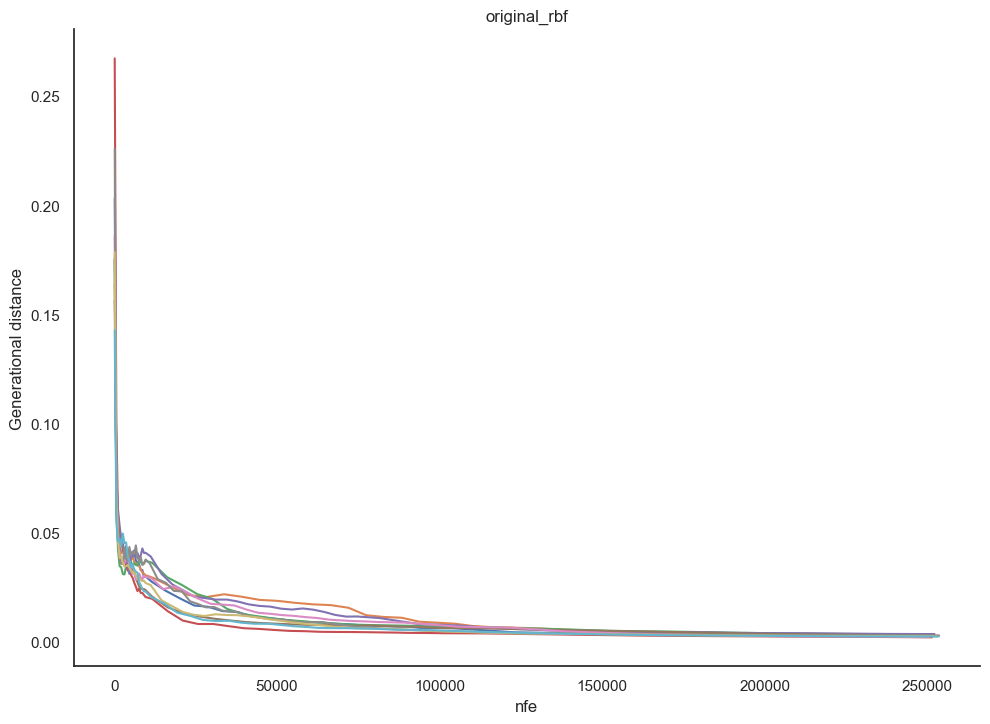

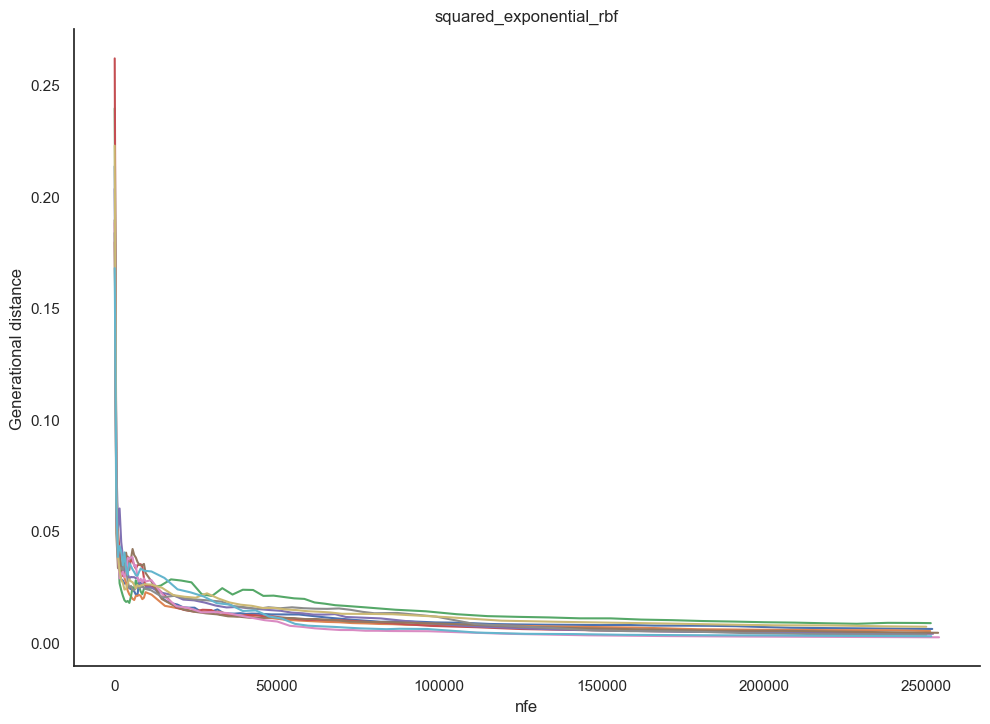

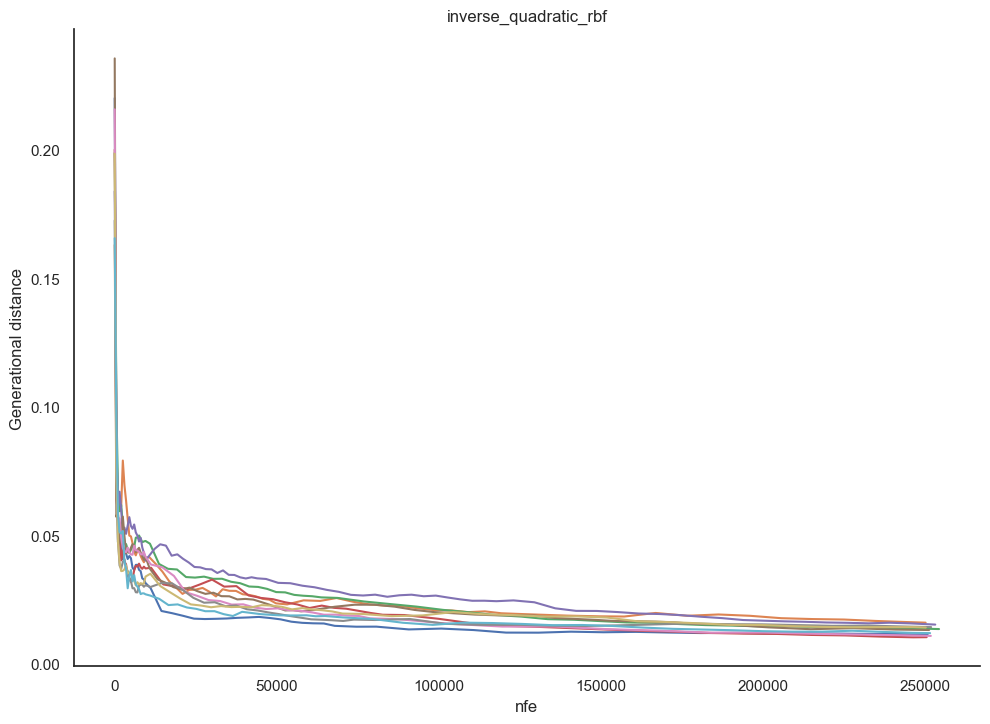

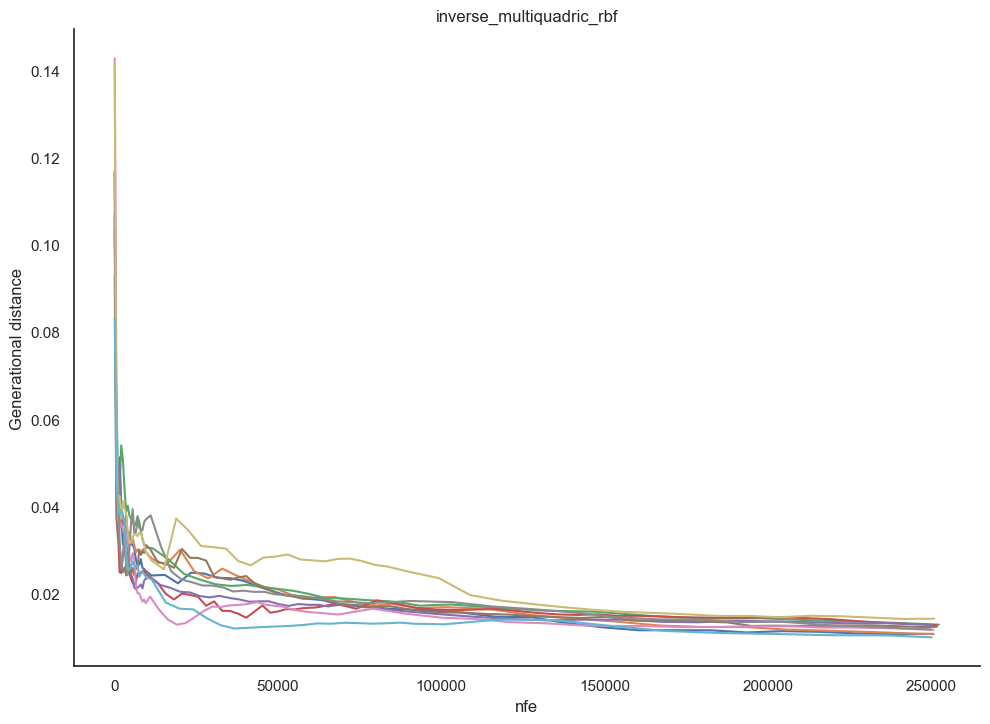

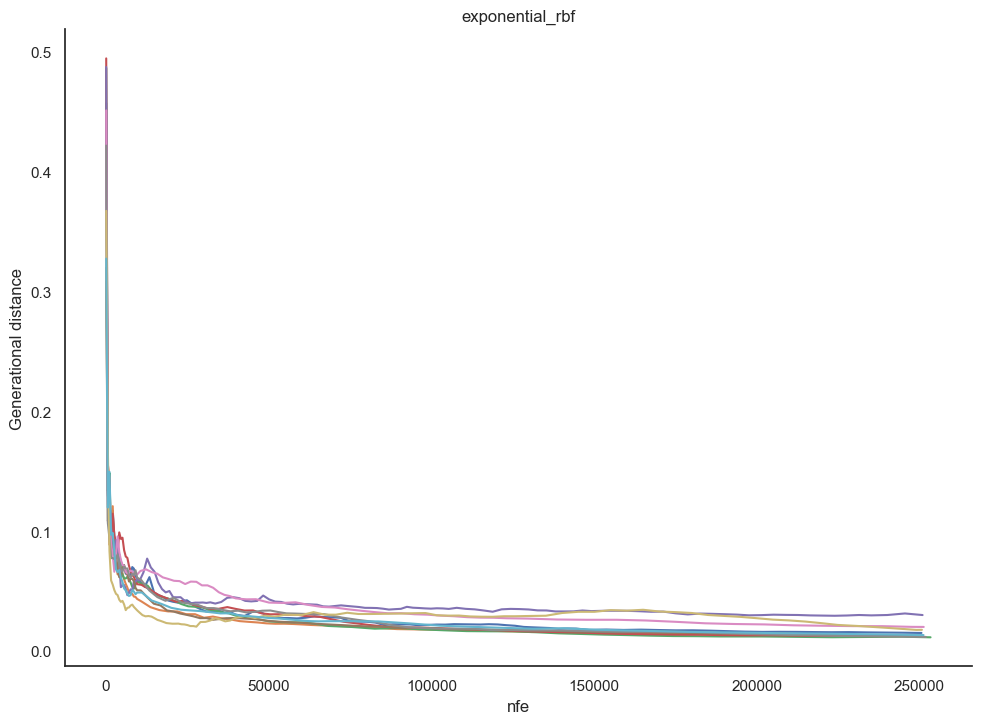

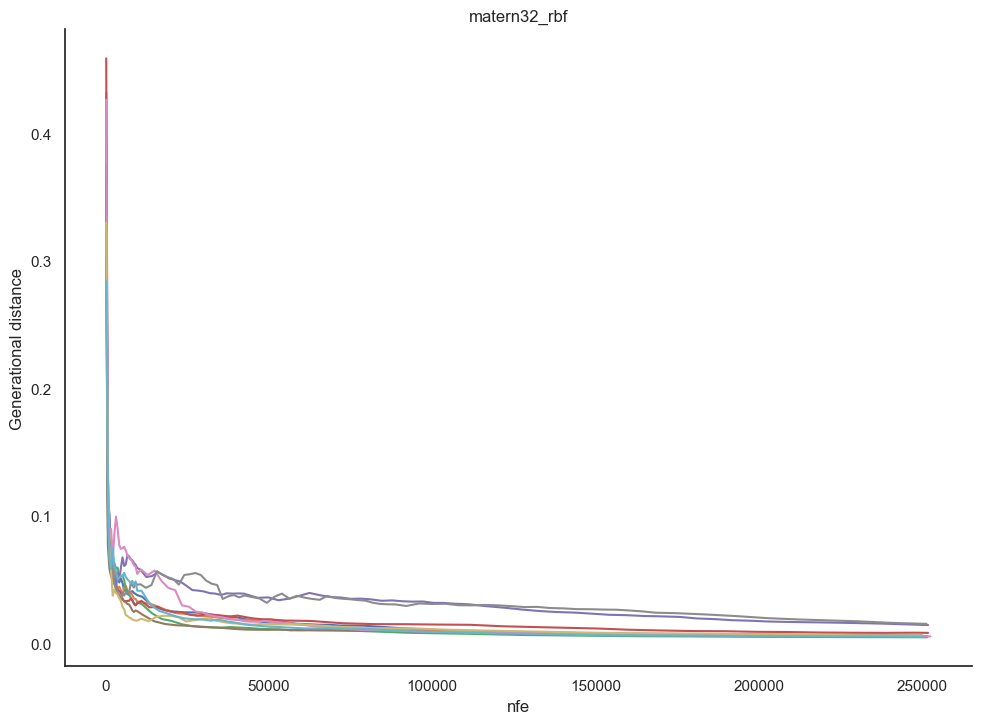

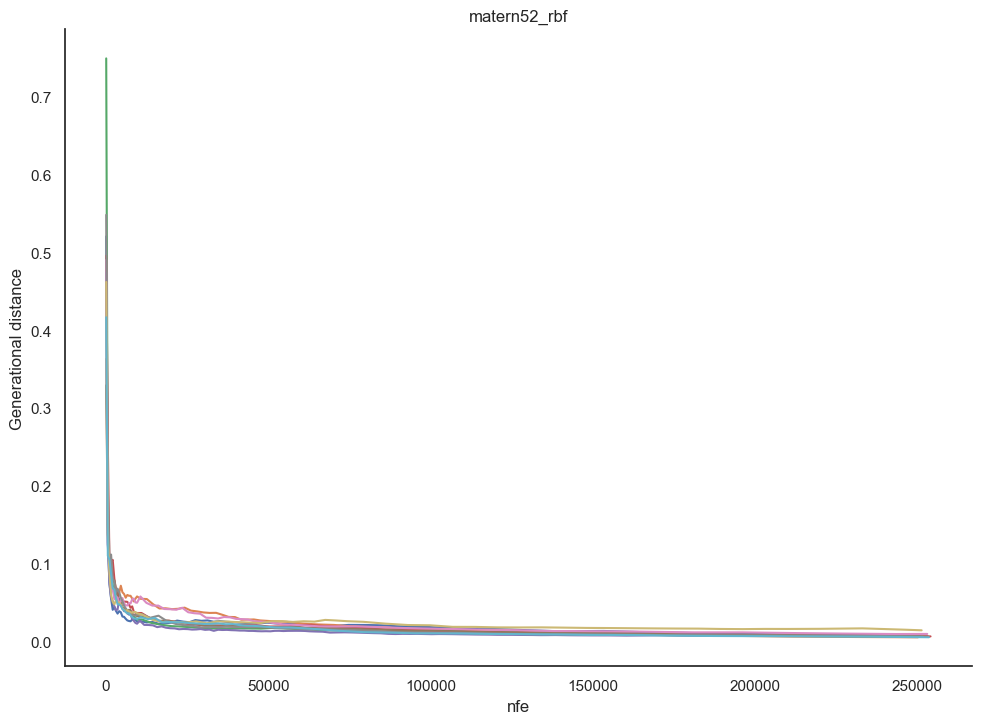

In [8]:
sns.set_style("white")
for entry in rbfs:
    name = entry.__name__
    gd = pd.DataFrame.from_dict(gd_sets[name], orient="index").T
    nfe = pd.DataFrame.from_dict(nfe_sets[name], orient="index").T

    fig, ax = plt.subplots()
    ax.plot(nfe, gd)
    ax.set_xlabel("nfe")
    ax.set_ylabel("Generational distance")
    ax.set_title(name)
    sns.despine()

    plt.show()

# Local reference set

FileNotFoundError: [Errno 2] No such file or directory: 'gd/inverse_quadratic_rbf_gd.csv'

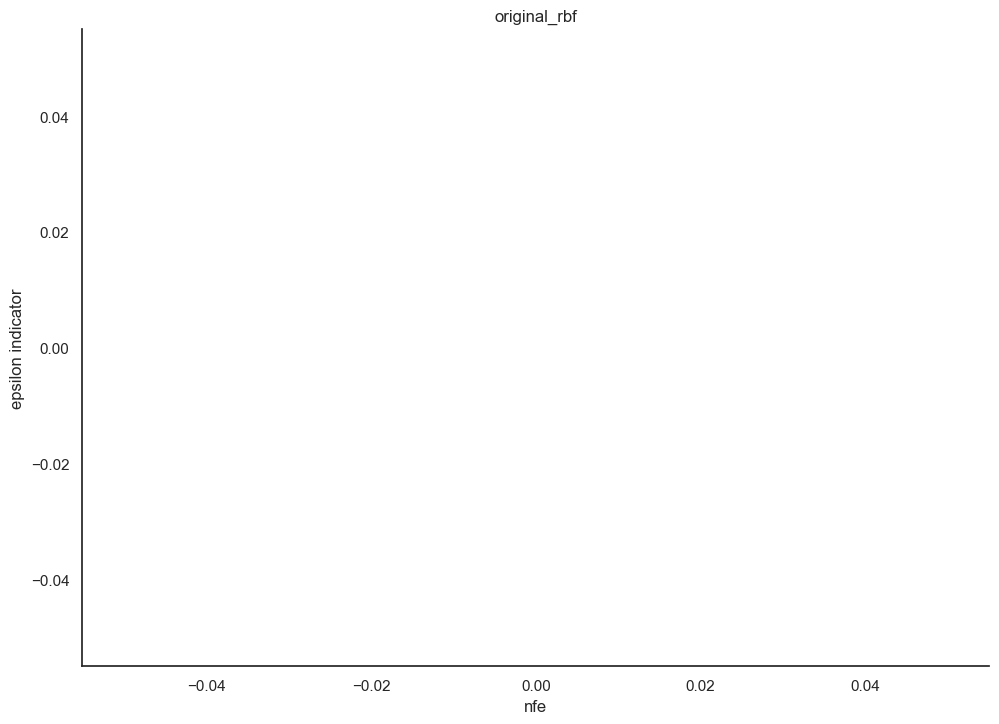

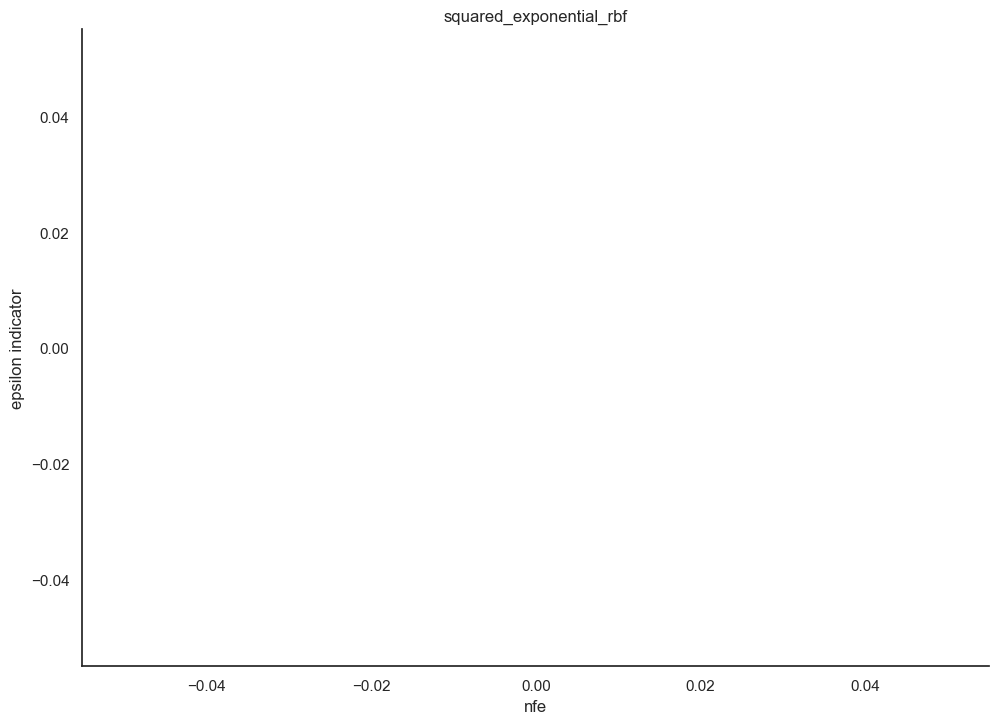

In [9]:
for entry, c in zip(rbfs, sns.color_palette()):
    rbf = entry.__name__
    df_gd = pd.read_csv(f"gd/{rbf}_gd.csv")
    df_gd_nfe = pd.read_csv(f"gd/{rbf}_gd_nfe.csv")
    fig, ax = plt.subplots(sharex=True)

    ax.plot(df_gd_nfe, df_gd, color=c)

    ax.set_xlabel("nfe")
    ax.set_ylabel("epsilon indicator")
    ax.set_title(rbf)
    sns.despine()
    plt.savefig(f"figs/{rbf}/{rbf}_gd.png")
plt.show()

# Global reference set

In [ ]:
for entry, c in zip(rbfs, sns.color_palette()):
    rbf = entry.__name__
    df_gd = pd.read_csv(f"gd_global/{rbf}_gd_all.csv")
    df_gd_nfe = pd.read_csv(f"gd_global/{rbf}_gd_nfe_all.csv")
    fig, ax = plt.subplots(sharex=True)

    ax.plot(df_gd_nfe, df_gd, color=c)

    ax.set_xlabel("nfe")
    ax.set_ylabel("epsilon indicator")
    ax.set_title(rbf)
    sns.despine()
#     plt.savefig(f'figs/{rbf}/{rbf}_gd_global.png')
plt.show()